<a href="https://colab.research.google.com/github/alejandrods/Numba/blob/master/Numba%20CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction CUDA (python) with Numba


Welcome to this notebook about Numba !!

Numba is a Python compiler, specifically for numerical functions and allows you to accelerate your applications with high performance functions written directly in Python.

Numba generates machine code optimized from pure Python code using LLVM. With a couple of simple changes, our Python code (function-oriented) can be optimized "just-in-time" to obtain a performance similar to that of C, C ++, without having to change the language.

## What is Numba?
Numba is a compiler that allows you to accelerate Python code (numerical functions) for both CPU and GPU:

1. Function Compiler: Numba compiles Python functions, not whole applications or parts of it. Basically, Numba is another Python module to improve the performance of our functions.

2. Just-in-time: (Dynamic translation) Numba translates the bytecode (intermediate code more abstract than the machine code) to machine code immediately before its execution to improve the execution speed.

3. Numerically-focused: Numba is focused on numerical data, such as `int`, `float`, `complex`. For now, there are limitations to use it with string data.

Numba is not the only way to program in CUDA, it is usually programmed in C / C ++ directly for it. But Numba allows you to program directly in Python and optimize it for both CPU and GPU with few changes in our code. In relation to Python, there are other alternatives such as pyCUDA, here is a comparison between them:


**CUDA C/C++:**
1. It is the most common and flexible way to program in CUDA
2. Accelerate applications in C, C ++.

**pyCUDA**
1. It is the most efficient CUDA form for Python
2. It requires programming C in our Python code and, in general, many code modifications.

<img src="https://images.slideplayer.com/16/5007566/slides/slide_50.jpg" alt="drawing" width="500"/>

**Numba**
1. Less efficient than pyCUDA
2. It allows you to write your code in Python and optimize it with few modifications
3. It also optimizes the Python code for CPU



## Goals

The objectives of this talk are the following:
* Use Numba to compile functions on the CPU
* Understand how Numba works
* Accelerate Numpy ufuncs in GPU
* Write Kernels using Numba (Next tutorial)




In [0]:
from numba import jit
import numpy as np
import math

# First steps: Compile for the CPU

Numba, apart from being able to speed up the functions in the GPU, can be used to optimize functions in the CPU. To do this, Python decorators (function modifiers) are used.

In [0]:
@jit
def hypot(x, y):
  return math.sqrt(x*x + y*y)

Evaluate

In [0]:
# Numba function
hypot(3.0, 4.0)

5.0

Numba saves the original implementation of the function in `.py_func`, we can execute it and see the response times.

In [0]:
# Python function
hypot.py_func(3.0, 4.0)

5.0

#### Benchmarking

Naturally, it is important to measure the performance of our code, check if Numba really works well and observe the difference between Python implementation and Numba implementation.

In [0]:
# Python function
%timeit hypot.py_func(3.0, 4.0)

The slowest run took 17.62 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 260 ns per loop


In [0]:
# Numba function
%timeit hypot(3.0, 4.0)

The slowest run took 33.89 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 216 ns per loop


The library `math` already includes the `hypot` function


In [0]:
# math function
%timeit math.hypot(3.0, 4.0)

The slowest run took 105.55 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 133 ns per loop


The `math.hypot` function is even faster than Numba!! This is because Numba introduces a certain overhead to each function call, which is larger than the Python function call overhead, very fast functions (like the previous one) will be affected by this.

(However, if you call a Numba function from another, there is very little overhead, sometimes even zero if the compiler integrates the function into the other. In short, check if the functions are really accelerating with Numba).

https://numba.pydata.org/numba-doc/dev/user/performance-tips.html#performance-tips


## How does Numba work?



When we initialize the `hypot` function:

![Image of Yaktocat](https://github.com/ContinuumIO/gtc2018-numba/raw/99e73d72b5c05e0d469b1e08574ea97d8ceb0800/img/numba_flowchart.png)

__IR__ Intermediate Representations

__Bytecode Analysis__ Intermediate code more abstract than machine code

__LLVM__ Low Level Virtual Machine, infrastructure to develop compilers

__NVVM__ It is an IR compiler based on LLVM, it is designed to represent GPU kernels

![Image of Yaktocat](https://media.giphy.com/media/3oKIPxVeeVSRDdZqSY/giphy.gif)


We can inspect the process for the `hypot` usego `.inspect_types ()`

Each line of python is preceded by several lines of Numba IR code. The most useful is to see the type annotations that show us how Numba treats the variables, for example, in "pyobject" it is indicating that Numba does not know the `np.sin` function and that he should call it from Python.

In [0]:
@jit
def foo_np(x):
  return np.sin(x)

foo_np(2)
foo_np.inspect_types()

foo_np (int64,)
--------------------------------------------------------------------------------
# File: <ipython-input-18-02574ac7ba04>
# --- LINE 1 --- 
# label 0

@jit

# --- LINE 2 --- 

def foo_np(x):

  # --- LINE 3 --- 
  #   x = arg(0, name=x)  :: int64
  #   $0.1 = global(np: <module 'numpy' from '/usr/local/lib/python3.6/dist-packages/numpy/__init__.py'>)  :: Module(<module 'numpy' from '/usr/local/lib/python3.6/dist-packages/numpy/__init__.py'>)
  #   $0.2 = getattr(value=$0.1, attr=sin)  :: Function(<ufunc 'sin'>)
  #   del $0.1
  #   $0.4 = call $0.2(x, func=$0.2, args=[Var(x, <ipython-input-18-02574ac7ba04> (3))], kws=(), vararg=None)  :: (int64,) -> float64
  #   del x
  #   del $0.2
  #   $0.5 = cast(value=$0.4)  :: float64
  #   del $0.4
  #   return $0.5

  return np.sin(x)




In [0]:
def sin(x):
  return np.sin(x)

@jit
def foo_sin(x):
    return sin(x)
 
foo_sin(2)
foo_sin.inspect_types()

foo_sin (int64,)
--------------------------------------------------------------------------------
# File: <ipython-input-19-59cff06a69bd>
# --- LINE 4 --- 
# label 0

@jit

# --- LINE 5 --- 

def foo_sin(x):

    # --- LINE 6 --- 
    #   x = arg(0, name=x)  :: pyobject
    #   $0.1 = global(sin: <function sin at 0x7f986dcdf378>)  :: pyobject
    #   $0.3 = call $0.1(x, func=$0.1, args=[Var(x, <ipython-input-19-59cff06a69bd> (6))], kws=(), vararg=None)  :: pyobject
    #   del x
    #   del $0.1
    #   $0.4 = cast(value=$0.3)  :: pyobject
    #   del $0.3
    #   return $0.4

    return sin(x)




#### Example: Creating fractals

With the following iterative method:

>$z_{n+1} = z_{n} + c$

For instance, for $c = -1$, the orbit of $z_{o} = 2$

>$z_{o} = 2$

>$z_{1} = 2^2 - 1 = 3$

>$z_{2} = 3^2 - 1 = 8$

If it does not diverge, it is called Fatou Set

1 loop, best of 3: 4.62 s per loop


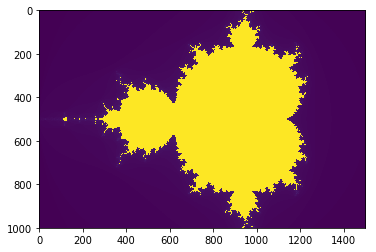

In [0]:
# Without Numba
from matplotlib.pylab import imshow, ion

def mandel(x, y, max_iters):
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
%timeit create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
img = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
imshow(img)

The slowest run took 4.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 52.4 ms per loop


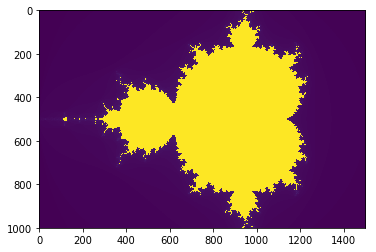

In [0]:
# With Numba
from matplotlib.pylab import imshow, ion

@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
%timeit create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
img = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
imshow(img)

#### Example: Montecarlo

In [0]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

(-5, 45)

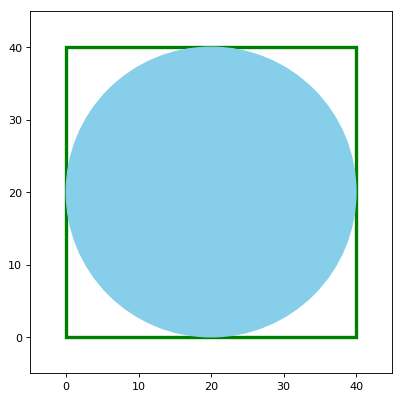

In [0]:
rad = 20
center = (rad, rad)

width = rad*2
height = rad*2
lims = (-5, 45)


fig1 = plt.figure(figsize=(8, 6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.add_patch(
    patches.Rectangle((0,0), width, height, edgecolor ='green', linewidth = 3,
                      fill=False))
ax1.add_patch(
    patches.Circle(center, rad, color = 'skyblue', fill=True))
plt.ylim(lims)
plt.xlim(lims)

In [0]:
iterations = 10000000

# Device function
@jit
def iteration():
  inside = 0

  for _ in range(iterations):
    xy = np.random.choice(a=rad, size=2, replace=False)

    x = xy[0]
    y = xy[1]
    b = (x - center[0])^2 + (y - center[1])^2 < rad^2

    if b:
      inside += 1
  return inside


%timeit iteration()
inside = iteration()

print('Inside points: ', inside)

1 loop, best of 3: 1.81 s per loop
Inside points:  8474305


Without Numba:

  - iterations = 10000000 -> 565 sg

"Montecarlo in Cuda" -> https://gist.github.com/akiross/17e722c5bea92bd2c310324eac643df6




In [0]:
print('Inside points: ', inside)
print('Outside points: ', iterations - inside)

Inside points:  8474305
Outside points:  1525695


$$SuperficieCuadrado = 4  \cdot r ^ 2$$

$$SuperficieCírculo = \pi \cdot r ^ 2$$

$$\frac{SuperficieCirculo}{SuperficieCuadrado}=\frac{\pi}{4}$$

Therefore, if we have done 100 iterations and 70 are within the circle, we can approximate the value of $ \pi $ using the following relationship:

$$\frac{70 }{100}=\frac{\pi}{4} \rightarrow  \pi = 4 \cdot \frac{70}{100} \approx 2.8	$$

In [0]:
pi_value = 4 * inside / iterations
print(pi_value)

3.389722


## Errors  

We have said that Numba only works for numeric functions, although Numba compiles and runs any Python code, there are some types of data that it cannot compile yet (such as dictionaries) and it also makes no sense to compile them.

In [0]:
@jit
def dictionary(dict_test):
  return dict_test['house']

dictionary({'house': 245, 'car': 350})

245

But it has not failed !! We have said that Numba does not compile dictionaries... The point here is that Numba creates 2 functions, one of them in Python and another in Numba. So here we are seeing the python solution, we can verify this by doing `nopython = True`.

In [0]:
@jit(nopython = True)
def dictionary(dict_test):
  return dict_test['house']

dictionary({'house': 245, 'car': 350})

TypingError: ignored

The `njit` function is equivalent to `jit(nopython = True)`

In [0]:
from numba import njit

@njit
def dictionary(dict_test):
  return dict_test['house']

dictionary({'house': 245, 'car': 350})

TypingError: ignored

# Numba for GPU

There are two ways to program in GPU using Numba:

__1.__   ufuncs/gufuncs__

__2.__  CUDA Python Kernels



In [0]:
# Usar Numba en GPU en Colab
!apt-get install nvidia-cuda-toolkit
!pip3 install numba

import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (9.1.85-3ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


## Functions ufunc

One of the main design features of the GPU is the ability to handle data in parallel, so the universal functions of numpy (ufunc) are an ideal candidate to implement them in GPU programming.

**_Note_**: ufunc are functions that perform the same operation on each element of a numpy array.

In [0]:
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([23, 341, 12, 5])

np.add(a, b)

array([ 24, 343,  15,   9])

Returns a new array, with the result of having performed the operation of adding to the array `a` the array `b`. It can also be used with scalars.

In [0]:
np.add(b, 200)

array([223, 541, 212, 205])

Arrays of different dimensions can also be operated using a technique called broadcasting. The array with the smallest dimension will be copied to match the dimensionality of the array with the largest dimension.

In [0]:
c = np.array([2, 3, 7, 8, 10, 34])
d = np.arange(6*6).reshape((6,6))

print('c array: \n', c)
print('\nd array: \n', d)
print('\n')

np.add(c, d)

c array: 
 [ 2  3  7  8 10 34]

d array: 
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]




array([[ 2,  4,  9, 11, 14, 39],
       [ 8, 10, 15, 17, 20, 45],
       [14, 16, 21, 23, 26, 51],
       [20, 22, 27, 29, 32, 57],
       [26, 28, 33, 35, 38, 63],
       [32, 34, 39, 41, 44, 69]])

### Making functions ufunc for GPU

As we have said before, the ufunc functions are an ideal candidate to use them with GPU because of their parallelism. Therefore, Numba has the ability to create compiled ufunc functions without using C. To do this, we must use the decorator `@vectorize`.

Let's start with an example using `@vectorize` to compile and optimize a CPU ufunc.

In [0]:
from numba import vectorize

a = np.array([1, 2, 3, 4])
b = np.array([23, 341, 12, 5])

@vectorize
def add_ufunc_cpu(a, b):
  return a + b

In [0]:
# Numba function
add_ufunc_cpu(a, b)

array([ 24, 343,  15,   9])

Instead of using the CPU to compile and execute the previous function, we are going to use CUDA in the GPU and for this we must use a "target attribute". We will indicate what type each variable is (arguments and return value).


`return_value_type(argument1_value_type, argument2_value_type, ...)`

To do this, we will use the previous function that expects 2 int64 values and returns another int64 value. We will designate `target = 'cuda'` to be able to execute it in the GPU.

In [0]:
@vectorize(['int64(int64, int64)'], target='cuda') 
def add_ufunc_gpu(x, y):
    return x + y

In [0]:
add_ufunc_gpu(a, b)

array([ 24, 343,  15,   9])

We can check the speed of running it on CPU or GPU

In [0]:
%timeit np.add(a, b)   # Numpy en CPU

The slowest run took 38.66 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 511 ns per loop


In [0]:
%timeit add_ufunc_gpu(a, b)   # Numpy en GPU

The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 755 µs per loop


GPU is slower than the CPU!!! Quiet, this has an explanation ... But first let's see what happens when we call that function
![ChessUrl](https://media.giphy.com/media/9M1ALCAKvXQKSf9Zfo/giphy.gif)


When we execute this function, Numba produces:



1. Compile a CUDA kernel to execute the ufunc function in parallel over all the elements of the input array
2. Assign the inputs and outputs to the GPU memory
3. Copy the input to the GPU
4. Run the CUDA Kernel
5. Copy the results back from the GPU to the CPU
6. Return the results as a numpy array

As compared to the implementation in C, Numba allows you to perform these types of tasks in a more concise way.

Why is the GPU slower than the CPU?


* Our inputs are too small: The GPU achieves better performance using pararelismo operating on thousands of values ​​at once. Our inputs are 4 or 64 dimensions, we need larger arrays to keep the GPU occupied.

* Very simple calculation: Sending the calculation to the GPU requires a lot of "effort" compared to calling the CPU function. If our function does not require excessive mathematical computation (this is usually called * arithmetic intensity *), then the GPU could take longer than in the CPU.

* Numba copies the data to the GPU

* The variable types of our inputs are larger than necessary: ​​Our example uses int64 and we probably do not need them. Practically, in CPU, 32 and 64-bits have the same computing speed, but in GPU, 64-bits have a slight increase in computational speed (it can reach up to 24x slower respectively to 32-bits). So it is important to keep this in mind when executing our function in the GPU.


With this in mind, we will try to apply what has been learned in the previous points to see if it is really faster to operate on the GPU than the CPU. We are going to calculate a density function, which is a slightly more complex operation with larger arrays.

Let's calculate the value of a Gaussian density function in `x` given the mean and sigma:

In [0]:
import math

sqrt_pi = np.float32((2*math.pi)**0.5) 

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_dens_gpu(x, mean, sigma):
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * sqrt_pi)
  
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

In [0]:
# Vamos a usar scipy para realizar el mismo cálculo pero en la CPU y comparánlo con la GPU
import scipy.stats 

norm_pdf = scipy.stats.norm

%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)  # CPU function

10 loops, best of 3: 60.8 ms per loop


In [0]:
%timeit gaussian_dens_gpu(x, mean, sigma) # GPU function

The slowest run took 24.61 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 6.88 ms per loop


Yeaah!!

![Ricky](https://media.giphy.com/media/3oKIPi2ELEdp4XFtVm/giphy.gif)

We can even define our function to be executed in the CPU using Numba.

In [0]:
import math 

sqrt_pi = np.float32((2*math.pi)**0.5)

@vectorize
def gaussian_dens_cpu(x, mean, sigma):
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * sqrt_pi)
  
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

%timeit gaussian_dens_cpu(x, mean, sigma) # CPU

10 loops, best of 3: 23.6 ms per loop


It is even faster than the function written in Python, but slower than the one executed in the GPU.

Unfortunately, there are several functions that do not fall within the scope of the definition of ufunc, therefore, to execute functions in the GPU that do not meet that requirement we use `cuda.jit`. We can use "device functions" that run on our GPU.

__*note*__: "devices functions" are functions that can only be called from a kernel or from another "device" function.

In [0]:
from numba import cuda

# Device function
@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [0]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [0]:
%timeit polar_distance(rho1, theta1, rho2, theta2)

The slowest run took 23.16 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 10.2 ms per loop


## CUDA Kernels

A kernel function is a GPU function that is called from the code in the CPU. Two points about the Kernerls:

1. Kernels cannot explicitly return a value: all results must be written to an array and passed to the function.

2. Kernels explicitly declare their threads when called


```
from numba import cuda

@cuda.jit
def my_kernel(io_array):
    """
    Code for kernel.
    """
    # code here



threadsperblock = 32
blockspergrid = (an_array.size + (threadsperblock - 1)) // threadsperblock
increment_by_one[blockspergrid, threadsperblock](an_array)
```



### To be continue...